# DIVA

Hao, Wei, et al. "A tale of two models: Constructing evasive attacks on edge models." Proceedings of Machine Learning and Systems 4 (2022): 414-429.

In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from aijack.attack import DIVAWhiteBoxAttacker
from aijack.utils import NumpyDataset

BASE = "data/"
torch.manual_seed(42)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
mnist_dataset_train = torchvision.datasets.MNIST(root="", train=True, download=True)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

X = mnist_dataset_train.train_data.numpy()
y = mnist_dataset_train.train_labels.numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, shuffle=True
)

# X_train = X_train[:2000]
# y_train = y_train[:2000]
# X_test = X_test[:1000]
# y_test = y_test[:1000]

train_dataset = NumpyDataset(
    X_train,
    y_train,
    transform=transform,
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=2
)

test_dataset = NumpyDataset(
    X_test,
    y_test,
    transform=transform,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=True, num_workers=2
)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y


class LMNet(nn.Module):
    def __init__(self):
        super(LMNet, self).__init__()
        self.fla = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 10)
        # self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.fla(x)
        x = self.fc1(x)
        # x = torch.relu(x)
        # x = self.fc2(x)
        # x = F.softmax(x, dim=1)
        return x

In [4]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

In [5]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0
    data_size = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.to(torch.int64))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        data_size += inputs.shape[0]

    print(f"epoch {epoch}: loss is {running_loss/data_size}")

in_preds = []
in_label = []
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "\nTest Accuracy is: ",
    accuracy_score(
        np.array(torch.argmax(in_preds, axis=1).cpu()), np.array(in_label.cpu())
    ),
)

epoch 0: loss is 0.04054302100458794
epoch 1: loss is 0.01814291013776199
epoch 2: loss is 0.0166187124224426
epoch 3: loss is 0.009562910017942598
epoch 4: loss is 0.002573704934469091
epoch 5: loss is 0.0021106714805702396
epoch 6: loss is 0.0017938830078365253
epoch 7: loss is 0.0015096701963636125
epoch 8: loss is 0.0014024900508528204
epoch 9: loss is 0.0010703933892566083

Test Accuracy is:  0.9825252525252526


In [6]:
net_distilled = LMNet().to(device)
criterion = nn.L1Loss()
optimizer = optim.SGD(net_distilled.parameters(), lr=0.003, momentum=0.9)

In [7]:
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0
    data_size = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = net(inputs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_distilled(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        data_size += inputs.shape[0]

    print(f"epoch {epoch}: loss is {running_loss/data_size}")

in_preds = []
in_label = []
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net_distilled(inputs)
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "\nTest Accuracy is: ",
    accuracy_score(
        np.array(torch.argmax(in_preds, axis=1).cpu()), np.array(in_label.cpu())
    ),
)

epoch 0: loss is 0.1670569335761948
epoch 1: loss is 0.15897891622574176
epoch 2: loss is 0.15708679305380258
epoch 3: loss is 0.1559841609742511
epoch 4: loss is 0.15508358281346696
epoch 5: loss is 0.15454466995315172
epoch 6: loss is 0.1539939962394202
epoch 7: loss is 0.15346056090065496
epoch 8: loss is 0.15314420309529375
epoch 9: loss is 0.15277839498436865
epoch 10: loss is 0.1524997589540719
epoch 11: loss is 0.15233479831052657
epoch 12: loss is 0.15207505247189632
epoch 13: loss is 0.1518335230018369
epoch 14: loss is 0.15169831540454087
epoch 15: loss is 0.15148778069078625
epoch 16: loss is 0.15128053859988255
epoch 17: loss is 0.15130577724667924
epoch 18: loss is 0.15122654953999307
epoch 19: loss is 0.15100575763491256

Test Accuracy is:  0.7185858585858586


In [8]:
c = 1.0
num_itr = 1000
eps = 0.15
lam = 0.03

torch.manual_seed(42)

idx = 0
x = torch.clone(inputs[[idx]])
x_origin = torch.clone(x)
y = labels[idx]

attacker = DIVAWhiteBoxAttacker(net, net_distilled, c, num_itr, eps, lam, device)
result = attacker.attack((x, y))

(-0.5, 27.5, 27.5, -0.5)

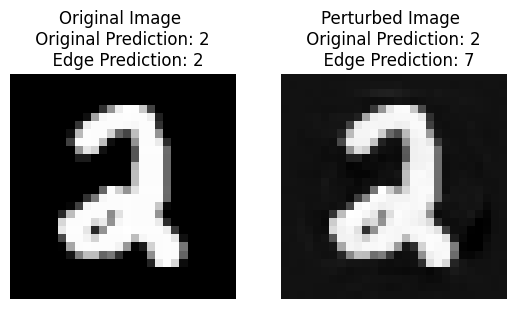

In [9]:
fig = plt.figure()

fig.add_subplot(121)
plt.imshow(inputs[[idx]].cpu()[0][0].detach().numpy(), cmap="gray")
plt.title(
    f"Original Image \n Original Prediction: {net(inputs[[idx]]).argmax().item()} \n  Edge Prediction: {net_distilled(inputs[[idx]]).argmax().item()}"
)
plt.axis("off")

fig.add_subplot(122)
plt.imshow(result[0].cpu()[0][0].detach().numpy(), cmap="gray")
plt.title(
    f"Perturbed Image \n Original Prediction: {net(result[0]).argmax().item()} \n  Edge Prediction: {net_distilled(result[0]).argmax().item()}"
)
plt.axis("off")